In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d #pre written interpolation function
from scipy.interpolate import griddata

In [2]:
def enum_other_states(n, num_step):
    """enumerate the state. using the following invariants
    (1) symetry (.1,.1,.8) is equivalent to (.1,.1,.8) from firm 1's pespective
    (2) the states must sum to 1"""
    
    states_i = np.arange(0,num_step+1)*(1./num_step)
    if n <=1:
        return states_i.reshape(num_step+1,1)
    else:
        states = []
        states_j = enum_other_states(n-1, num_step)
        for i in states_i:
            for j in states_j:
                if j[0] >= i and (j.sum() + i <= 1):
                    state_ij = np.concatenate( ([i],j) )
                    states.append(state_ij)
        states = np.array(states)
        return  states

In [3]:
class States:
    """class for dealing with the states to ensure
    invariants are kept"""
    
    my_states = None #type nparray
    other_states = None #type np array 2d
    n = 0 #number of players
    num_step = 0 #number of states (states normalized between 0 and 1)
    

    def __init__(self, n, num_step):
        """initialize important class attributes"""
        self.n, self.num_step = n, num_step
      
    
    def gen_states(self):
        """compute all relevant states for firm i
        the trick is enforcing invariants in the helper"""
        self.other_states =  enum_other_states(self.n-1, self.num_step)
        self.my_states = 1 - self.other_states.sum(axis=1)
        
    
    def get_len(self):
        return len(self.other_states)
    
    
    def get_all(self):
        """return all the states"""
        reshaped_states = self.my_states.reshape((len(self.my_states),1))
        return np.concatenate( (reshaped_states, self.other_states), axis=1 )
    
    
    def make_states(self, my_states, other_states):
        """special initializer for states enforcing the invariants"""
        
        assert np.array(other_states).shape[1] == (self.n -1)
        
        #make a copy to avoid side effects
        new_states = States(self.n, self.num_step)
        
        #combine into 1 array
        other_states = np.sort(other_states)
        my_states = np.array(my_states).reshape((len(my_states),1))
        all_states = np.concatenate((my_states,other_states),axis=1)
        all_states = np.maximum(0, all_states )

        #re-weight states
        denom = all_states.sum(axis=1)
        denom = np.repeat(denom,self.n).reshape(all_states.shape)
        all_states = all_states/denom
        
        #return states
        new_states.my_states = all_states[:,0]
        new_states.other_states = np.delete(all_states,0,axis=1)
        
        return new_states

states = States(3, 10)
states.gen_states()
new_states = states.make_states([1.5],[[.5,-1.]])

print new_states.get_all()

[[0.75 0.   0.25]]


In [4]:
def create_function(states, values):
    """returns a function and its max values
    the function uses the grid data to figure out return value"""
    f = lambda eval_states: griddata(states.get_all(), values, 
                                     eval_states.get_all() ,method='nearest')
       
    return f, np.amax(values)


states = States(3, 10)
states.gen_states()
new_states = states.make_states([.3],[[.3,.3]])
values = np.concatenate([np.ones(states.get_len()/2),4*np.ones(states.get_len()/2)])
policy0,max0 = create_function(states,values)
print policy0(new_states)

[4.]


In [5]:
def calc_bids(policy, states):
    """return the other players bids
    given the state by 'switching perspective'
    to other firm"""
    
    other_bids = []
    for i in range(1,states.n):
        other_states = states.get_all()
        my_other = other_states[:,i]
        other = np.delete(other_states, i, axis=1)
        other_states = states.make_states(my_other, other)
        other_bids.append( policy(other_states) )
    return np.array(other_bids).transpose()

In [6]:
def cost(states, shock,theta):
    """return the cost for firm 0"""
    return  shock + theta*states.my_states


def weighting(bids):
    """return weighting when there's a tie"""
    n_states, n_players = bids.shape
    low_bid =  np.min(bids,axis=1)
    low_bid = np.repeat(low_bid, n_players).reshape(n_states,n_players)
    
    #winners
    win = (bids <= low_bid)
    n_winners = win.sum(axis=1)*1.
    n_winners = np.repeat(n_winners, n_players).reshape(n_states,n_players)
    
    #add loosers
    lose = (bids > low_bid)
    n_loosers = np.maximum(lose.sum(axis=1)*1.,1.)
    n_loosers = np.repeat(n_loosers, n_players).reshape(n_states,n_players)
    
    return win/(1.*n_winners), lose/(1.*n_loosers)


def profit(bids, states, contract, shock, theta):
    """return firm 0's profit"""
    my_bids = bids[:,0]
    win_weights, lose_weights = weighting(bids)
    profits = contract*win_weights[:,0]*(my_bids - cost(states,shock,theta))  
    return profits


def update_state(bids, states, contract):
    """update all firms states based on bids
    note: firms in updated states, no longer correspond to their bids"""
    win_weights, lose_weights = weighting(bids)
    new_states = contract*win_weights - contract*lose_weights + states.get_all()
    return states.make_states(new_states[:,0],np.delete(new_states,0,axis=1))


states = States(3, 10)
states.gen_states()
values = np.concatenate([np.ones(states.get_len()/2),2*np.ones(states.get_len()/2)])
policy, peak = create_function(states, values)
new_states = states.make_states([1.],[[0,0]])

bids = np.array([[1,1,1]])

update_state(bids,new_states,.1).get_all()

array([[0.93939394, 0.03030303, 0.03030303]])

In [7]:
def gen_sim_bid_states(bids, states, shock):
    """tile the states B x NSIM times"""
    
    #save lengths for later
    n_bids = bids.shape[0]
    n_shock = shock.shape[0]
    
    #repeat bids/states per each bid
    my_bids = np.repeat(bids,states.get_len()*n_shock)
    shock = np.repeat(shock,states.get_len())
    shock = np.tile(shock,n_bids)
    
    bid_states = states.get_all()
    bid_states = np.tile(bid_states,(n_bids*n_shock,1))
    bid_states = states.make_states(bid_states[:,0],np.delete(bid_states,0,axis=1))
    
    return my_bids, bid_states, shock



def operator(v_init, p_init, bids, states, shock, theta, beta):
    """update the value and the policy function for player 0
    
    since we are looking for symmetric eq, there is really just 1
    policy and value to keep track of"""
    
    #generate all bids x sims x states
    my_bids, bid_states, all_shock = gen_sim_bid_states(bids, states, shock)
    
    #other bids in each bid state and concat with my bids
    other_bids = calc_bids(p_init, bid_states)
    all_bids = my_bids.reshape(bid_states.get_len(),1)
    all_bids = np.concatenate((all_bids,other_bids), axis=1)
    
    #initialize contract to 0
    contract = .3
    
    #print bid_states.get_all()
    
    #calculate see how the states would update
    next_states = update_state(all_bids, bid_states, contract)
    
    #calculate the value of the next state
    value = profit(all_bids, bid_states, contract,  all_shock, theta)
    value = value + beta*v_init(next_states)
    
    #reshape v_new to find argmax
    value = value.reshape((len(bids),len(shock),states.get_len()))
    #use argmax to find policy/value functions
    policy = np.argmax(value,axis=0)
    policy = bids[policy].mean(axis=0)
    policy, p_max = create_function(states, policy) 
    
    value = np.max(value,axis=0).mean(axis=0)
    value, v_max = create_function(states, value)
    
    return  value, v_max, policy, p_max


#run the operator
states = States(3, 5)
shock = np.random.normal(3,3,2)
states.gen_states()
values = np.concatenate([np.ones(states.get_len()/2),2*np.ones(states.get_len()/2)])
policy, peak = create_function(states, values)
bids = np.arange(1,3)

value, v_max, policy, p_max = operator(policy, policy, bids, states, shock, 5, .9)

#run a test or two
new_states = states.make_states([1.],[[0,0]])
print policy(new_states)

[2.]


In [8]:
def  markov_perfect_eq(error, maxiter, value, policy, bids, states, shock, theta, beta):
    """calculate the value function in a symmetric
        markov perfect equilibria"""
    
    #initialize loop variables
    policy_conv = True
    value_conv = True #don't worry about value function for now
    p0_max, v0_max = -1,-1 #ensure the loop goes once
    
    while  maxiter >= 0 and (policy_conv or value_conv) :
        
        #iterate loop variables for each player
        value, v_max, policy, p_max = operator(value, policy, bids, states, shock, theta, beta)
            
        #update loop variables
        maxiter = maxiter -1
        policy_conv = np.abs(v_max - v0_max) > error
        value_conv = np.abs(p_max - p0_max ) > error
        v0_max, p0_max = v_max,p_max
    
    return  value, policy

In [9]:
def gen_cross(states):
    """gen cross section for purposes of graphing policy"""
    my_states = np.arange(0,states.num_step+1)*(1./states.num_step)

    #equalize other market shares
    fixed = (1 - my_states)/(states.n-1)
    fixed = np.repeat(fixed, states.n-1 )
    fixed_states = fixed.reshape(states.num_step + 1 , states.n-1)   

    return states.make_states(my_states,fixed_states)


def graph_functions(function, cross_sections, labels):
    """graph function on predetermined cross section"""
    for i in range(len(function)):
        #set up labels
        fig = plt.figure()
        plt.xlabel("Firm i's State")
        plt.ylabel("Firm i's %s Function"%labels[i])
        for cross in cross_sections:
            plt.plot( cross.my_states, function[i](cross), label=str(cross.other_states[0]) )
        plt.legend()

        
#states = States(5,7)
cross_section = gen_cross(states)


p = policy(cross_section).reshape(cross_section.get_len(),1)
v = value(cross_section).reshape(cross_section.get_len(),1)
print np.concatenate((cross_section.get_all(),p,v),axis=1)

[[0.         0.5        0.5        2.         1.8       ]
 [0.2        0.4        0.4        2.         1.42791623]
 [0.4        0.3        0.3        2.         1.32791623]
 [0.6        0.2        0.2        2.         1.22791623]
 [0.8        0.1        0.1        2.         0.9       ]
 [1.         0.         0.         2.         1.8       ]]


In [20]:
#Decreasing returns to scale (i.e. incumbency disadvantage, both games seem to admit this eq)

bids = np.arange(1,15)*.16
n= 3
step = 10
shock = np.random.normal(2,.5,40) #np.array([2])
states = States(n,15)
states.gen_states()
values = np.concatenate([1.8*np.ones(states.get_len()/2),2*np.ones(states.get_len()/2)])
policy, p_max = create_function(states, values)
value, policy = markov_perfect_eq(.0001, 200, policy, policy, bids, states, shock, 1, .9)

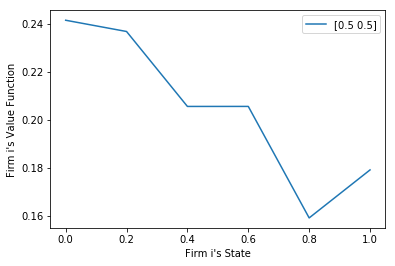

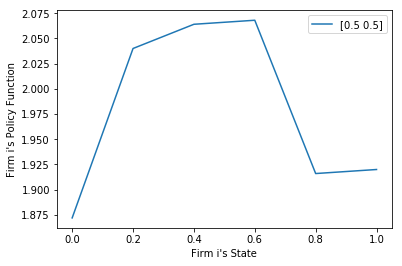

In [21]:
graph_functions( (value,policy),[cross_section],['Value','Policy'])

In [22]:
#second eq (i.e. incumbency disadvantage, bid low early on and high later (this one is cyclic?) )

bids = np.arange(1,15)*.16
n= 3
step = 10
shock = np.random.normal(2,.5,40) #np.array([2])
states = States(n,15)
states.gen_states()
values = np.concatenate([1.4*np.ones(states.get_len()/2),1.4*np.ones(states.get_len()/2)])
policy, p_max = create_function(states, values)
value, policy = markov_perfect_eq(.0001, 200, policy, policy, bids, states, shock, 1, .9)

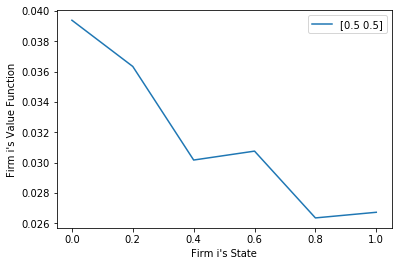

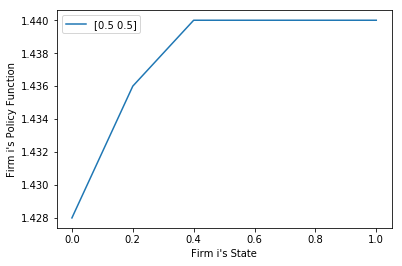

In [23]:
graph_functions( (value,policy),[cross_section],['Value','Policy'])

In [14]:
#incresaing 
bids = np.arange(1,15)*.16
n= 3
step = 10
shock = np.random.normal(2,.5,40) #np.array([2])
states = States(n,15)
states.gen_states()
values = np.concatenate([1.3*np.ones(states.get_len()/2),1.3*np.ones(states.get_len()/2)])
policy, p_max = create_function(states, values)
value, policy = markov_perfect_eq(.0001, 200, policy, policy, bids, states, shock, -1, .9)

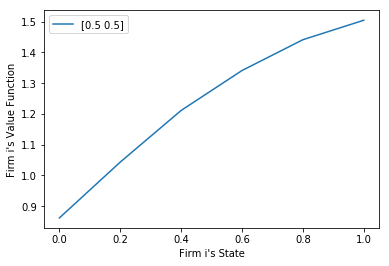

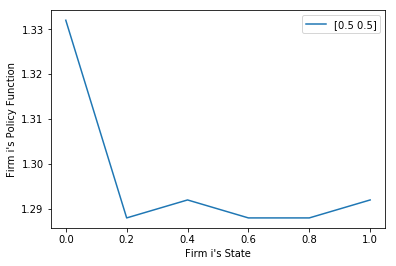

In [15]:
graph_functions( (value,policy),[cross_section],['Value','Policy'])